Submitted by: Manmeet Singh (013906919)

## Requirements 
* (done) Apply **mini-batch gradient descent** with appropriate batch size
* (done) Use appropriate **learning rate** (can be adaptive per epoch)
* (done) Apply **dropout** - find appropriate dropout rate at each layer
* (partial - default) Initialize random **weights** properly before training
* (done) Do basic image **augmentation** of training data using Keras
* (done) Use **3 or more layers** with appropriate **number of neurons** per layer
* (done) Use **relu activation layer** in the right places
* (done) **Normalize and scale** the input before training with Keras
* (partial) Include **metrics**: testing, training accuracy and confusion matrix

In [713]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

In [714]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

## Load dataset

In [715]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [716]:
x_train.shape

(60000, 28, 28)

In [717]:
x_test.shape

(10000, 28, 28)

In [718]:
x_train = x_train[0:2000]
y_train = y_train[0:2000]

In [719]:
y_train_raw = y_train.copy()
y_test_raw = y_test.copy()

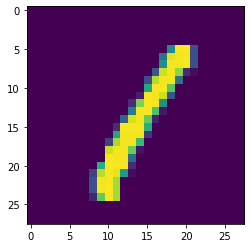

In [720]:
g = plt.imshow(x_train[3][:,:])

## Training dataset augmentation

Using Keras Datagen

In [721]:
x_train_augmented = x_train[0:500]
y_train_augmented = y_train[0:500]

In [722]:
x_train_augmented = x_train_augmented.reshape(-1,28,28,1)

In [723]:
x_train_augmented.shape

(500, 28, 28, 1)

In [724]:
# Augment 1k training dataset images
# Reference: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_augmented)

In [725]:
# Use datagen.flow to obtain the entire batch at once and prepend to original dataset.
x_train2 = None
for x_batch, y_batch in datagen.flow(x_train_augmented, y_train_augmented, batch_size=len(x_train_augmented)):
    x_train2 = x_batch
    break

In [726]:
# Re-shape the augmented dataset into (num_instances, width, height)
x_train_augmented = x_train2.reshape(len(x_train_augmented), 28, 28)

In [727]:
x_train[0:500] = x_train_augmented

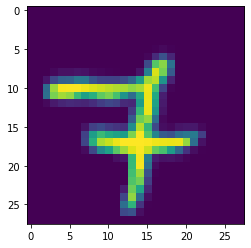

In [728]:
g = plt.imshow(x_train_augmented[3][:,:])

#### The above two images look the same..

In [729]:
np.array_equal(x_train_augmented[5], x_train[5])

False

#### Looks like Keras datagen actually did some augmentation. Not enough to be visible

## Scaling and Normalization
The training data is 1 3D array of (digit_label, pixel width, pixel height). For our MLP to run gradient descent, the width and height must be converted into a vector of 784 pixels.

This is accomplished using numpy's reshape() function.

In [730]:
num_pixels = x_train.shape[1] * x_train.shape[2]

# Scale input (examples, width, height) --> (examples, width*height)
x_train = x_train.reshape((x_train.shape[0], num_pixels)).astype('float32')
x_test = x_test.reshape((x_test.shape[0], num_pixels))

In [731]:
# Normalize pixel values from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

## One hot encode the labels

One hot encoding essentially transforms the categorical values into a matrix where their existence or absence is marked by 1 or 0, respectively.

In [732]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## Training functions

* Relu
* Mini-batch gradient descent based train()

In [733]:
def relu(x):
    return (x >= 0) * x

def relu2deriv(output):
    return output >= 0

In [734]:
'''
Runs a 3 layer mini batch gradient descent 

@ params: images
@ retval: metrics -> (correct_cnt, error, )
''' 
def train(images, labels, test_images, test_labels):
    train_correct = {}
    train_incorrect = {}
    test_correct = {}
    test_incorrect = {}
    batch_size = 64

    alpha, iterations = (0.0009, 250)
    
    # MNIST dataset specific settings and hidden layer neuron size
    pixels_per_image, num_labels, hidden_size_1, hidden_size_2 = (784, 10, 128, 64)

    # Weight initialization for various layers -- # of neurons based on the tuple passed to np.random
    weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size_1)) - 0.1
    weights_1_2 = 0.2 * np.random.random((hidden_size_1, hidden_size_2)) - 0.1
    weights_2_3 = 0.2 * np.random.random((hidden_size_2, num_labels)) - 0.1
    
    
    for j in range(iterations):
        error, correct_cnt = (0.0, 0)
      
        for i in range(int(len(images) / batch_size)):
            batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))
            
            # Layer 0 is batchsize * 784 elts
            layer_0 = images[batch_start:batch_end]
            
            # Layer 1 is [batchsize X 784 elts] * [784 X hidden_size_1] --> batchsize X hidden_size_1 
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            l1_dropout_mask = np.random.randint(2, size=layer_1.shape)
            layer_1 *= l1_dropout_mask * 2
            
            # Layer 2 [batchsize X hidden_size_1] * [hidden_size_1 X hidden_size_2] --> batchsize X hidden_size_2 
            layer_2 = relu(np.dot(layer_1, weights_1_2))
            l2_dropout_mask = np.random.randint(2, size=layer_2.shape)
            layer_2 *= l2_dropout_mask * 2
            
            # Layer 3 is softmax layer
            layer_3 = np.dot(layer_2, weights_2_3)
            
            # MSE between the network initialization and training label -- how well did you init your random weights?
            error += np.sum((labels[batch_start:batch_end] - layer_3) ** 2)
            
            # Update weights for images in the batch - same deltas are recalculated in each iteration
            for k in range(batch_size):
                # Correct training predictions -- compare each image in batch to layer_3 output
                if int(np.argmax(layer_3[k:k+1])) == np.argmax(labels[batch_start+k:batch_start+k+1]):
                    correct_cnt += 1
                    
                    # Save metrics of correct training predictions
                    raw_val = int(y_train_raw[batch_start+k:batch_start+k+1])
                    if raw_val in train_correct:
                        train_correct[raw_val] = train_correct[raw_val] + 1
                    else: 
                        train_correct[raw_val] = 1   
                else:
                    raw_val = int(y_train_raw[batch_start+k:batch_start+k+1])
                    if raw_val in train_incorrect:
                        train_incorrect[raw_val] = train_incorrect[raw_val] + 1
                    else: 
                        train_incorrect[raw_val] = 1  
                    # ----------- end metrics --------------------
                    
                layer_3_delta = (labels[batch_start:batch_end] - layer_3) / batch_size
                layer_2_delta = layer_3_delta.dot(weights_2_3.T) * relu2deriv(layer_2)
                layer_2_delta *= l2_dropout_mask
                layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
                layer_1_delta *= l1_dropout_mask
                
                # Update weights while iterating through the batch
                weights_2_3 += alpha * layer_2.T.dot(layer_3_delta)
                weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
                weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

        # Check accuracy against test set and print metrics
        if(j%10 == 0):
            test_error = 0.0
            test_correct_cnt = 0

            for i in range(len(test_images)):
                layer_0 = test_images[i:i+1]
                layer_1 = relu(np.dot(layer_0,weights_0_1))
                layer_2 = relu(np.dot(layer_1, weights_1_2))
                layer_3 = relu(np.dot(layer_2, weights_2_3))
                
                # MSE
                test_error += np.sum((test_labels[i:i+1] - layer_3) ** 2)
                
                # Save testing metrics
                if int(np.argmax(layer_3) ==  np.argmax(test_labels[i:i+1])):
                    test_correct_cnt += 1
                    raw_val = int(y_test_raw[i:i+1])
                    if raw_val in test_correct:
                        test_correct[raw_val] = test_correct[raw_val] + 1
                    else: 
                        test_correct[raw_val] = 1   
                else:
                    raw_val = int(y_test_raw[i:i+1])
                    if raw_val in train_incorrect:
                        test_incorrect[raw_val] = train_incorrect[raw_val] + 1
                    else: 
                        test_incorrect[raw_val] = 1  
                # ----------- end metrics --------------------
                
            # Reference for metrics: http://howieko.com/study/regularization/
            sys.stdout.write("\n" + \
            "I:" + str(j) + \
            " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
            " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+\
            " Train-Err:" + str(error/ float(len(images)))[0:5] +\
            " Train-Acc:" + str(correct_cnt/ float(len(images))))
    return train_correct, train_incorrect, test_correct, test_incorrect

## Metrics

In [736]:
train_correct, train_incorrect, test_correct, test_incorrect = train(x_train, y_train, x_test, y_test)


I:0 Test-Err:0.883 Test-Acc:0.2574 Train-Err:1.042 Train-Acc:0.124
I:10 Test-Err:0.756 Test-Acc:0.6048 Train-Err:0.825 Train-Acc:0.3145
I:20 Test-Err:0.658 Test-Acc:0.6656 Train-Err:0.772 Train-Acc:0.4185
I:30 Test-Err:0.607 Test-Acc:0.7234 Train-Err:0.735 Train-Acc:0.462
I:40 Test-Err:0.569 Test-Acc:0.7532 Train-Err:0.719 Train-Acc:0.475
I:50 Test-Err:0.547 Test-Acc:0.7723 Train-Err:0.716 Train-Acc:0.4925
I:60 Test-Err:0.534 Test-Acc:0.7856 Train-Err:0.692 Train-Acc:0.4995
I:70 Test-Err:0.520 Test-Acc:0.79 Train-Err:0.696 Train-Acc:0.5155
I:80 Test-Err:0.522 Test-Acc:0.7831 Train-Err:0.701 Train-Acc:0.5075
I:90 Test-Err:0.525 Test-Acc:0.7807 Train-Err:0.687 Train-Acc:0.5175
I:100 Test-Err:0.520 Test-Acc:0.775 Train-Err:0.683 Train-Acc:0.5235
I:110 Test-Err:0.516 Test-Acc:0.7825 Train-Err:0.682 Train-Acc:0.5245
I:120 Test-Err:0.509 Test-Acc:0.7744 Train-Err:0.690 Train-Acc:0.522
I:130 Test-Err:0.511 Test-Acc:0.7806 Train-Err:0.681 Train-Acc:0.532
I:140 Test-Err:0.507 Test-Acc:0.7801 T

### Training

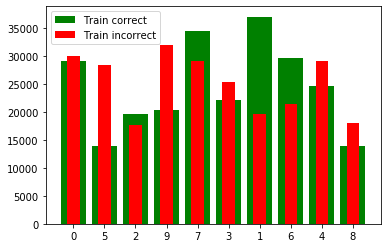

In [737]:
plt.bar(range(len(train_correct)), list(train_correct.values()), align='center', width=0.8, color='g', label='Train correct')
plt.bar(range(len(train_incorrect)), list(train_incorrect.values()), align='center', width=0.4, color='r', label='Train incorrect')

plt.xticks(range(len(train_correct)), list(train_correct.keys()))

plt.legend()

plt.show()

### Testing

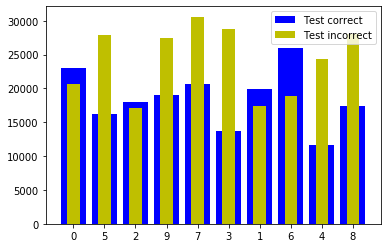

In [740]:
plt.bar(range(len(test_correct)), list(test_correct.values()), align='center', width=0.8, color='b', label='Test correct')
plt.bar(range(len(test_incorrect)), list(test_incorrect.values()), align='center', width=0.4, color='y', label='Test incorrect')

plt.xticks(range(len(test_correct)), list(train_correct.keys()))

plt.legend()

plt.show()

In [ ]:
train_incorrect